In [1]:
# Modules
from qiskit.quantum_info import Pauli, SparsePauliOp
from itertools import combinations
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize
from functools import reduce


In [2]:
# Les valeurs / exemples
#n = 3  n_qubits = P_i, un seul générateur → P_i qubits
q=2 #bits par générateur 
P_i   = [3,2]          # granularité (3 qubits)
c_i   = [10,8]       # coût linéaire
D_i   = [30,20]        # demande par noeud
D_tot=np.sum(D_i)

lam=100
P_ij={(0,1):3}



In [3]:
liste = list(range(q))
alpha_m=[0,1,2,4,6] # Pour représenter 360 degrés
couples = [(i, j) for i in range(q+1) for j in range(i, q+1)]


x_vars = [(i, j) for i in range(q) for j in range(i+1, q)]
beta_vars = [(i, s, m) for i in liste for m in range(5) for s in range(m+1, 5)] # beta_sm=beta_ms ?????
#c_vars=[(r,i,s) for i in liste for r in range(int(np.log2(P_i[i]+1))) for s in range (r)]

c_vars = [
    (i, s)
    for i in liste
    for s in range(int(np.ceil(np.log2(P_i[i] + 1)))
)
]
c_vars2=[(i,j,p) for i in liste for j in range(i+1, q) for p in range(int(np.ceil(np.log2(P_ij[(i,j)] + 1))))]
c_vars3= [(i,j,p) for i in liste for j in range(i+1, q) for p in range(int(np.ceil(np.log2(P_ij[(i,j)] + 1))))]

all = x_vars + beta_vars + c_vars + c_vars2+ c_vars3
qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}
offset = len(x_vars)
for k, (i,s,m) in enumerate(beta_vars):
    qubit_index[f"beta_{i}_{s}_{m}"] = offset + k
    
offset = len(x_vars) + len(beta_vars)
for k, (i, s) in enumerate(c_vars):
    qubit_index[f"c_{i}_{s}"] = offset + k
    
offset=len(x_vars) + len(beta_vars)+ len(c_vars)
for k, (i,j,p) in enumerate (c_vars2):
    qubit_index[f"c2_{i}_{j}_{p}"]=offset+k
    
offset=len(x_vars) + len(beta_vars)+ len(c_vars)+ len(c_vars3)
for k, (i,j,p) in enumerate (c_vars3):
    qubit_index[f"c3_{i}_{j}_{p}"]=offset+k


n_qubit = len(all)



In [4]:
#Pour coder les index
def idx_x(i, j):
    return qubit_index[f"x_{i}_{j}"]

def idx_beta(i, s, m):
    return qubit_index[f"beta_{i}_{s}_{m}"]

def idx_c(i,r):
    return qubit_index[f"c_{i}_{r}"]

def idx_c2(i,j,p):
    return qubit_index[f"c2_{i}_{j}_{p}"]

def idx_c3(i,j,p):
    return qubit_index[f"c3_{i}_{j}_{p}"]

In [5]:
terms = []
B_ij = {(0,1): 1.0 }

for i in range(q):
    for j in range(i+1, q):
        if (i,j) not in B_ij:
            continue
        Bij = B_ij[(i,j)]
        for m in range(5):  # M: nombre de "modes" alpha
            for s in range(m+1,5):  # S: nombre de bits pour l'encodage binaire
                alpha = alpha_m[m]
                coeff = (alpha / 4.0) * (2**s) * (lam + c_i[i]) * Bij

                x_idx = idx_x(i,j)
                b_i_idx = idx_beta(i,s,m)
                b_j_idx = idx_beta(j,s,m)

                # - Z_x * Z_beta_j
                pauli = ['I'] * n_qubit
                pauli[x_idx] = 'Z'
                pauli[b_j_idx] = 'Z'
                terms.append((''.join(pauli), -coeff))

                # + Z_x * Z_beta_i
                pauli = ['I'] * n_qubit
                pauli[x_idx] = 'Z'
                pauli[b_i_idx] = 'Z'
                terms.append((''.join(pauli), coeff))

                # + Z_beta_j
                pauli = ['I'] * n_qubit
                pauli[b_j_idx] = 'Z'
                terms.append((''.join(pauli), coeff))

                # - Z_beta_i
                pauli = ['I'] * n_qubit
                pauli[b_i_idx] = 'Z'
                terms.append((''.join(pauli), -coeff))


In [6]:
for i in range(q):
    for j in range(i+1, q):
        terms.append(('I'*n_qubit, -P_ij[(i,j)]+ 2 * D_i[i]-P_i[i] ))    


In [7]:
for i in range(q):
    ki=int(np.ceil(np.log2(P_i[i] + 1)))
    for r in range(ki):
            c_idx = idx_c(i, r)  # mapping des qubits c_{r,i}
            coeff = 2**(r-1)

            # 1 * coeff (pour le "1" dans (1 - Z))
            terms.append(('I'*n_qubit, coeff))

            # -Z_c * coeff
            pauli = ['I'] * n_qubit
            pauli[c_idx] = 'Z'
            terms.append((''.join(pauli), -coeff))


In [8]:
for i in range(q):
    
    for j in range(i+1,q):
        kij=int(np.ceil(np.log2(P_ij[(i,j)]+1)))

        for p in range(kij):
            c2_idx = idx_c2(i,j, p)  
            coeff = 2**(p-1)

            # 1 * coeff (pour le "1" dans (1 - Z))
            terms.append(('I'*n_qubit, coeff))

            # -Z_c * coeff
            pauli = ['I'] * n_qubit
            pauli[c2_idx] = 'Z'
            terms.append((''.join(pauli), -coeff))

In [ ]:
for i in range(q):
    
    for j in range(i+1,q):
        kij=int(np.ceil(np.log2(P_ij[(i,j)]+1)))

        for p in range(kij):
            c3_idx = idx_c3(i,j, p)  
            coeff = 2**(p-1)

            terms.append(('I'*n_qubit, coeff))

            pauli = ['I'] * n_qubit
            pauli[c3_idx] = 'Z'
            terms.append((''.join(pauli), -coeff))

In [10]:
H_c = SparsePauliOp.from_list(terms)


In [11]:
#Définition de L'Hamiltonien de mélange
from qiskit.quantum_info import SparsePauliOp

H_M2 = SparsePauliOp.from_list([
    ('I'*i + 'X' + 'I'*(n_qubit-i-1), 1.0)
    for i in range(n_qubit)
])

print(H_M2)


SparsePauliOp(['XIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IXIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIXIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIXIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIXIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIXIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIXIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIXIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIXIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIXIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIXIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIXIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIXIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIXIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIXIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIX'],
              coeffs=[1.+0.

In [ ]:
from qiskit.circuit.library import PauliEvolutionGate
def U_C(gamma, H):
    gate = PauliEvolutionGate(H, time=gamma)
    return gate.definition  

def U_M(beta, H):
    gate = PauliEvolutionGate(H, time=beta)
    return gate.definition


In [ ]:
from qiskit import QuantumCircuit

# Construction du circuit QAOA --> SANS mesure
def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n)  
    qc.h(range(n))          
    
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    
    return qc 


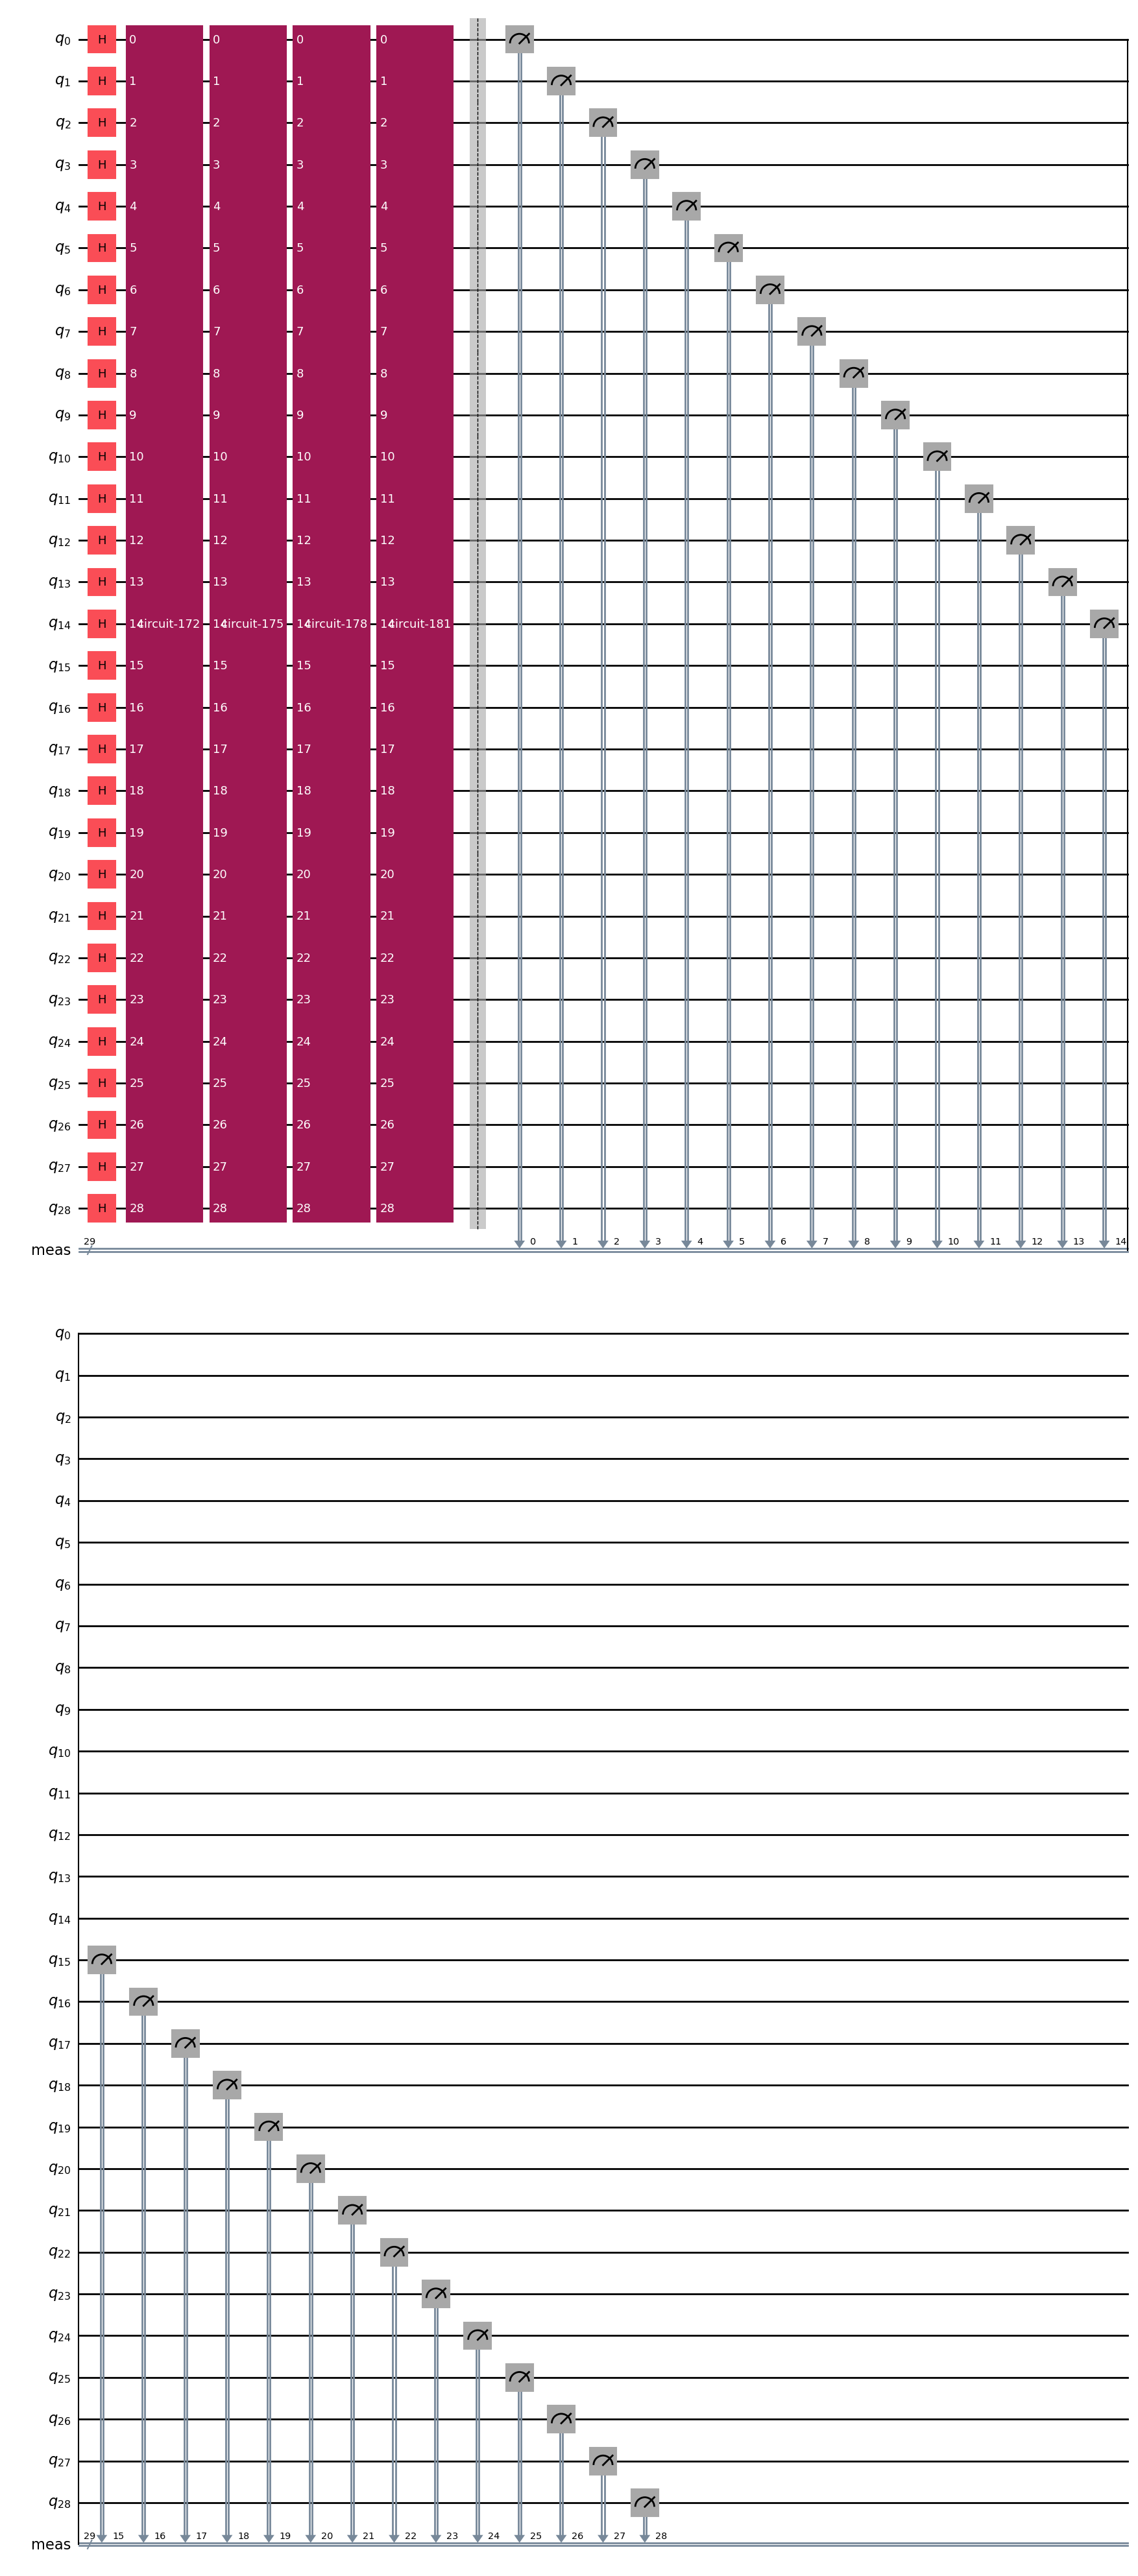

In [14]:
import pylatexenc
p=2
gammas=[np.pi/4, np.pi/2]
betas=[np.pi/8, np.pi/4]
params=[np.pi/4, np.pi/2, np.pi/8, np.pi/4 ]
cost_h=H_c
mixer_h=H_M2
qc2=build_qaoa_circuit(n_qubit,p,gammas,betas,cost_h,mixer_h)
qc2.measure_all()
qc2.draw("mpl")


# Affichage du résultat très long --> Plusieurs valeurs

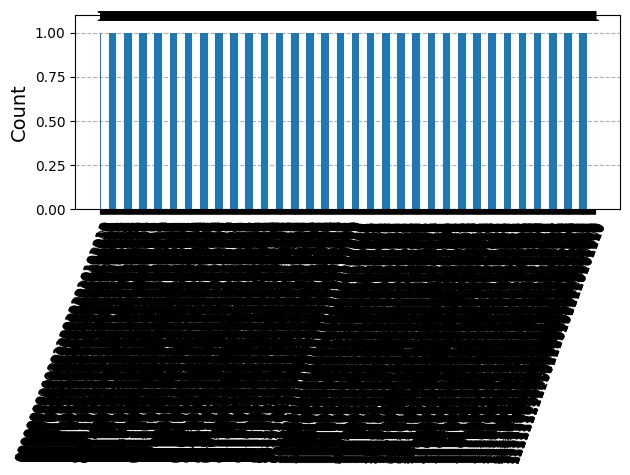

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator  
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


qc_transpiled2 = transpile(qc2, AerSimulator())

job = AerSimulator().run(qc_transpiled2, shots=1024)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)


In [ ]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize

backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    p = 2
    gammas = params[:p]
    betas = params[p:]
    
    qc2 = build_qaoa_circuit(n_qubit, p, gammas, betas, H_c, H_M2)
    qc2.save_statevector()
    
    qc_transpiled = transpile(qc2, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return -np.real(expval)  # on maximise le coût en minimisant l'opposé




In [17]:

result = minimize(qaoa_expectation, params, method='COBYLA')

print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", -result.fun)


Paramètres optimaux : [1.88831382 2.71349233 0.31690987 0.99449908]
Espérance d'énergie minimale : 1590.4284411561484


In [18]:
# Récupérer le bitstring le plus probable après exécution
best_bitstring = max(counts, key=counts.get)
print("Bitstring le plus probable :", best_bitstring)
print("Nombre d'occurrences :", counts[best_bitstring])


Bitstring le plus probable : 10010101111011000001010101110
Nombre d'occurrences : 1


In [19]:
inv_index = {v: k for k, v in qubit_index.items()} # j'inverse le dict

bit_values = {}
for i, bit in enumerate(best_bitstring):
    var_name = inv_index[i]
    bit_values[var_name] = int(bit)



In [22]:
x_values = {k: v for k, v in bit_values.items() if k.startswith("x_")}
beta_values = {k: v for k, v in bit_values.items() if k.startswith("beta_")}
c_values = {k: v for k, v in bit_values.items() if k.startswith("c_")}
c2_values={k: v for k, v in bit_values.items() if k.startswith("c2_")}
c3_values={k: v for k, v in bit_values.items() if k.startswith("c3_")}


for var_group, values in [("x_vars", x_values), ("beta_vars", beta_values), ("c_vars", c_values), ("c2_vars", c2_values), ("c3_vars", c3_values)]:
    print(f"{var_group}:")
    for var, val in sorted(values.items()):
        print(f"  {var} = {val}")



x_vars:
  x_0_1 = 1
beta_vars:
  beta_0_1_0 = 0
  beta_0_2_0 = 0
  beta_0_2_1 = 1
  beta_0_3_0 = 1
  beta_0_3_1 = 0
  beta_0_3_2 = 1
  beta_0_4_0 = 0
  beta_0_4_1 = 1
  beta_0_4_2 = 1
  beta_0_4_3 = 1
  beta_1_1_0 = 0
  beta_1_2_0 = 1
  beta_1_2_1 = 0
  beta_1_3_0 = 1
  beta_1_3_1 = 0
  beta_1_3_2 = 0
  beta_1_4_0 = 0
  beta_1_4_1 = 0
  beta_1_4_2 = 1
  beta_1_4_3 = 0
c_vars:
  c_0_0 = 1
  c_0_1 = 0
  c_1_0 = 1
  c_1_1 = 0
c2_vars:
  c2_0_1_0 = 1
  c2_0_1_1 = 1
c3_vars:
  c3_0_1_0 = 1
  c3_0_1_1 = 0
